<h3> SUBMISSION: Proyek Pertama : Membuat Model NLP dengan TensorFlow <h3>
<h4> Delvin Fachrizky

In [37]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [48]:
# PENGGUNAAN CALLBACK

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\n accuracy is above > 90%")
      self.model.stop_training=True
callbacks = myCallback()

In [2]:
# MENYIAPKAN DATASET
dtfrm = pd.read_csv("kaggle_dataset.csv")
dtfrm.head()

,id,text,genre
0,0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
1,2,"t, summa cum laude and all. And I'm about to l...",comedy
2,3,"up Come, I have a surprise.... She takes him ...",drama
3,4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
4,5,"nd dismounts, just as the other children reach...",drama


In [3]:
# MELIHAT VALUE DARI KOLOM GENRE
dtfrm['genre'].value_counts()

drama        8873
thriller     6824
comedy       2941
action       2392
sci-fi        613
horror        456
other         270
adventure     147
romance        63
Name: genre, dtype: int64

In [35]:
# MENYISIHKAN GENRE YANG TIDAK DIGUNAKAN UNTUK KALI INI DAN HANYA MENGGUNAKAN 3 CONTOH GENRE YAITU COMEDY, ACTION, DAN HORROR
dtfrm = dtfrm[~dtfrm['genre'].isin(['drama','thriller','other','adventure','romance', 'sci-fi'])]
dtfrm['genre'].value_counts()

comedy    2941
action    2392
horror     456
Name: genre, dtype: int64

In [38]:
# MENGHAPUS KARAKTER YANG TIDAK DIGUNAKAN
dtfrm['Text'] = dtfrm['text'].map(lambda x: re.sub(r'\W+', ' ', x))
# MENGHAPUS KOLOM ID DAN TEXT
dtfrm = dtfrm.drop(['id', 'text'], axis=1)
dtfrm.head()

,genre,Text
1,comedy,t summa cum laude and all And I m about to lau...
9,action,e reels as the world spins Sweat pours off him...
20,comedy,I say he s a man who ll go far Some people sa...
25,comedy,you find out where the bachelor party is COLE ...
29,comedy,ibly horrendous public break up on the quad Ag...


In [39]:
# MEMBERIKAN LABEL GENRE
genre = pd.get_dummies(dtfrm.genre)
dtfrm_genre = pd.concat([dtfrm, genre], axis=1)
dtfrm_genre = dtfrm_genre.drop(columns='genre')
dtfrm_genre.head()

,Text,action,comedy,horror
1,t summa cum laude and all And I m about to lau...,0,1,0
9,e reels as the world spins Sweat pours off him...,1,0,0
20,I say he s a man who ll go far Some people sa...,0,1,0
25,you find out where the bachelor party is COLE ...,0,1,0
29,ibly horrendous public break up on the quad Ag...,0,1,0


In [41]:
# MENKONVERSI TIPE DATA MENJADI STR DAN MEMBUATNYA KE DALAM NUMPY ARRAY
txt = dtfrm_genre['Text'].astype(str)
label = dtfrm_genre[['action', 'horror', 'comedy']].values

In [42]:
# MEMBUAT SPLIT DATASET SEBESAR 20% (TEST/VALIDATION)
g_train, g_test, l_train, l_test = train_test_split(txt, label, test_size=0.2)

In [55]:
# PEMODELAN SEQUENTIAL DENGAN EMBEDDING DAN LSTM 
# TOKENIZER
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(g_train)

seq_train = tokenizer.texts_to_sequences(g_train)
seq_test = tokenizer.texts_to_sequences(g_test)

pad_train = pad_sequences(seq_train, maxlen=200, truncating="post")
pad_test = pad_sequences(seq_test, maxlen=200, truncating="post")

sq_train = tokenizer.texts_to_sequences(g_train)
sq_test = tokenizer.texts_to_sequences(g_test)

print(pad_test.shape)

(1158, 200)


In [60]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64, input_length=200),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 200, 64)           320000    
                                                                 
 lstm_10 (LSTM)              (None, 128)               98816     
                                                                 
 dense_20 (Dense)            (None, 128)               16512     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 3)                 387       
                                                                 
Total params: 435,715
Trainable params: 435,715
Non-trainable params: 0
_________________________________________________________________


In [61]:
# WAKTU YANG DIBUTUHKAN HANYA KURAND DARI 2 MENIT

num_epochs = 30
history = model.fit(pad_train, l_train, epochs=num_epochs, 
                    validation_data=(pad_test, l_test), verbose=2, callbacks=[callbacks])

Epoch 1/30
145/145 - 14s - loss: 0.9108 - accuracy: 0.5118 - val_loss: 0.7736 - val_accuracy: 0.7323 - 14s/epoch - 95ms/step
Epoch 2/30
145/145 - 12s - loss: 0.4380 - accuracy: 0.8469 - val_loss: 0.3426 - val_accuracy: 0.8860 - 12s/epoch - 86ms/step
Epoch 3/30
145/145 - 13s - loss: 0.2376 - accuracy: 0.9331 - val_loss: 0.3516 - val_accuracy: 0.8860 - 13s/epoch - 86ms/step
Epoch 4/30
145/145 - 13s - loss: 0.0994 - accuracy: 0.9724 - val_loss: 0.3703 - val_accuracy: 0.8679 - 13s/epoch - 87ms/step
Epoch 5/30

 accuracy is above > 90%
145/145 - 13s - loss: 0.0610 - accuracy: 0.9829 - val_loss: 0.2917 - val_accuracy: 0.9180 - 13s/epoch - 87ms/step


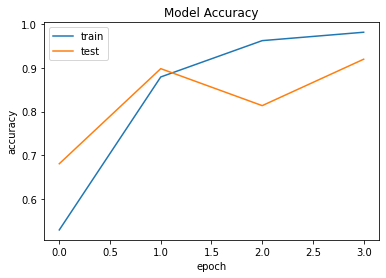

In [46]:
# MEMBUAT GRAFIK VISUALISASI DARI MODEL ACCURACY
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

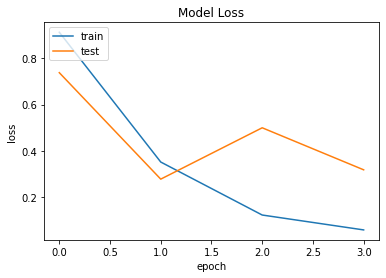

In [47]:
# MEMBUAT GRAFIK VISUALISASI DARI MODEL LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()